---
title: "Análisis de proyección cambios componentes"
subtitle: "DANTOTSU"
author: "Departamento Confiabilidad"
date: today
---

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import dagster as dg

from kdags.definitions import *
from kdags.readr import *

context = dg.build_asset_context()
from kdags.assets.planning.component_changeouts.assets import *
from IPython.display import Markdown

# from kdags.assets.reparation.reso.service_order_scraper import *

dl = DataLake(context)
msgraph = MSGraph(context)
from kdags.assets.docs.io_catalog import *
from kdags.config.catalog_loader import DATA_CATALOG
from datetime import datetime
from theme_komatsu import *
from great_tables import GT, md

In [19]:
pcp_repair_costs_df = dl.read_tibble(DATA_CATALOG["pcp_repair_costs"]["raw_path"])
gfa_ovh_rates_df = (
    dl.read_tibble(DATA_CATALOG["gfa_overhaul_rates"]["raw_path"])
    .select(
        [
            "model_name",
            "component_name",
            "subcomponent_name",
            "mtbo",
            "gfa_overhaul_rate",
        ]
    )
    .drop_nulls("component_name")
).with_columns(gfa_overhaul_rate=pl.col("gfa_overhaul_rate").round(0).cast(pl.Int64))
file_content = dl.read_bytes("az://bhp-raw-data/PLANNING/PAM/PPTO_FY2025.xlsx")
# GT(pcp_repair_costs_df.filter(pl.col("model_name") == "960E").to_pandas()).tab_options(
#     table_font_size="footnotesize", container_width="100%"  # LaTeX size command
# )

2025-06-11 09:45:42 -0400 - dagster - INFO - system - Reading data from Azure path: az://bhp-raw-data/REFERENCE/pcp_repair_costs.xlsx
2025-06-11 09:45:44 -0400 - dagster - INFO - system - Successfully read data from: az://bhp-raw-data/REFERENCE/pcp_repair_costs.xlsx
2025-06-11 09:45:44 -0400 - dagster - INFO - system - Data shape: 60 rows, 13 columns
2025-06-11 09:45:44 -0400 - dagster - INFO - system - Reading data from Azure path: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
Could not determine dtype for column 0, falling back to string
2025-06-11 09:45:44 -0400 - dagster - INFO - system - Successfully read data from: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
2025-06-11 09:45:44 -0400 - dagster - INFO - system - Data shape: 17 rows, 7 columns


## Análisis del PAM

In [20]:
component_df = MasterData.components()
equipments = MasterData.equipments()
positions_df = MasterData.positions()
df = pd.read_excel(
    BytesIO(file_content), skiprows=5, sheet_name="PAM Gnral", usecols="A:AC", dtype=str
)

df = (
    pl.from_pandas(df)
    .select(
        [
            "Cod Comp RMCare",
            "Faena",
            "Modelo",
            "Cod Pos RMCare",
            "Fecha de Cambio",
            "Hrs Proy de cambio",
            "Costo",
            "Cantidad",
            "%USO",
            "NRO INT.",
            "Motivo de Cambio",
        ]
    )
    .rename(
        {
            "Cod Comp RMCare": "subcomponent_tag",
            "Cod Pos RMCare": "position_tag",
            "Hrs Proy de cambio": "proj_component_hours",
            "Fecha de Cambio": "proj_changeout_date",
            "Faena": "site_name",
            "Modelo": "model_name",
            "Costo": "pam_repair_cost",
            "Cantidad": "cc_amount",
            "%USO": "component_usage",
            "NRO INT.": "pam_equipment_name",
            "Motivo de Cambio": "changeout_reason",
        }
    )
).with_columns(
    proj_changeout_date=pl.col("proj_changeout_date").str.to_date(
        "%Y-%m-%d %H:%M:%S", strict=False
    ),
    proj_component_hours=pl.col("proj_component_hours").cast(
        pl.Float64, strict=False
    ),  ##Revisar
    cc_amount=pl.col("cc_amount").cast(pl.Int64),
    pam_repair_cost=pl.col("pam_repair_cost").cast(pl.Float64),
    component_usage=pl.col("component_usage").cast(pl.Float64, strict=False).round(0),
    model_name=pl.col("model_name").replace(
        {
            "960E-1": "960E",
            "960E-2": "960E",
        }
    ),
    changeout_reason=pl.col("changeout_reason").fill_null(pl.lit("unknown")),
)
df = df.filter(pl.col("model_name").is_in(["930E-4", "960E", "980E-5"]))
# df = df.drop_nulls(["proj_changeout_date", "proj_component_hours"])
df = df.filter(pl.col("site_name") == "Escondida")
df = df.join(
    component_df.select(["subcomponent_tag", "component_name", "subcomponent_name"]),
    on="subcomponent_tag",
    how="left",
).join(
    positions_df.select(["position_name", "position_tag"]),
    on="position_tag",
    how="left",
)

# Agregar costos medios PCP
pcp_merge_columns = [
    "site_name",
    "model_name",
    "subcomponent_tag",
    "position_tag",
]
df = df.join(
    pcp_repair_costs_df.select([*pcp_merge_columns, "mean_repair_cost", "tbo"]),
    on=pcp_merge_columns,
    how="left",
    validate="m:1",
)


def calculate_prorrata_sale(df):
    """
    Calculate prorrata_sale (Costo Prorrata) using vectorized Polars operations

    Formula:
    - If component_hours in range [mtbo, mtbo*1.05]: gfa_overhaul_rate * (1 + ((effective_hours - mtbo) / mtbo))
    - Otherwise: gfa_overhaul_rate * (effective_hours / mtbo)

    Args:
        df: DataFrame with required columns from schema

    Returns:
        DataFrame with updated 'prorrata_sale' column
    """

    result_df = df.with_columns(
        [
            # Calculate effective hours: M = MIN(component_hours, mtbo_105)
            pl.min_horizontal(
                [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
            ).alias("effective_hours"),
            # Apply prorrata formula
            pl.when(
                # Condition: effective_hours >= mtbo AND effective_hours <= mtbo*1.05
                (
                    pl.min_horizontal(
                        [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                    )
                    >= pl.col("mtbo")
                )
                & (
                    pl.min_horizontal(
                        [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                    )
                    <= pl.col("mtbo") * 1.05
                )
            )
            .then(
                # Case 1: Hours in normal range (100% to 105%)
                pl.col("gfa_overhaul_rate")
                * (
                    1
                    + (
                        (
                            pl.min_horizontal(
                                [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                            )
                            - pl.col("mtbo")
                        )
                        / pl.col("mtbo")
                    )
                )
            )
            .otherwise(
                # Case 2: Hours outside normal range
                pl.col("gfa_overhaul_rate")
                * (
                    pl.min_horizontal(
                        [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                    )
                    / pl.col("mtbo")
                )
            )
            .fill_null(0.0)
            .round(0)
            .alias("prorrata_sale"),  # Final column name
        ]
    ).drop(
        ["effective_hours"]
    )  # Clean up intermediate column

    return result_df


df = df.join(
    gfa_ovh_rates_df,
    how="left",
    on=["model_name", "component_name", "subcomponent_name"],
).pipe(calculate_prorrata_sale)

### Diferencia entre costo proyectado PAM y costo medio

In [28]:
diff_df = df.with_columns(
    delta_cost=pl.col("pam_repair_cost")
    - (pl.col("mean_repair_cost") * pl.col("cc_amount"))
).filter(
    abs(pl.col("delta_cost")) >= 500
)  # .write_excel("diferencia_costos.xlsx")
GT(
    diff_df.select(
        [
            "component_name",
            "position_name",
            # "equipment_name",
            "proj_changeout_date",
            "proj_component_hours",
            "pam_repair_cost",
            "delta_cost",
        ]
    ).rename(
        {
            "component_name": "Componente",
            "proj_changeout_date": "Fecha CC",
            "proj_component_hours": "Hrs Comp",
            "position_name": "Posición",
            "pam_repair_cost": "Costo PAM",
        }
    )
).tab_options(
    table_font_size="footnotesize", container_width="100%"  # LaTeX size command
)

Componente,Posición,Fecha CC,Hrs Comp,Costo PAM,delta_cost
modulo_potencia,unico,2025-06-15,16732.5,0.0,-52746.21
modulo_potencia,unico,2025-06-15,16732.5,0.0,-28804.05
modulo_potencia,unico,2025-06-15,16732.5,0.0,-90812.7
modulo_potencia,unico,2025-06-28,16529.5,0.0,-52746.21
modulo_potencia,unico,2025-06-28,16529.5,0.0,-28804.05
modulo_potencia,unico,2025-06-28,16529.5,0.0,-90812.7
modulo_potencia,unico,2025-04-01,16341.5,0.0,-52746.21
modulo_potencia,unico,2025-04-01,16341.5,0.0,-28804.05
modulo_potencia,unico,2025-04-01,16341.5,0.0,-90812.7
motor_traccion,derecho,2025-04-01,29280.5,0.0,-38120.94



| Nº | Subcomponente              | Registros | Delta total | Delta medio/fila |
|----|----------------------------|-----------|-------------|------------------|
| 1  | **maza**                   | 6         | **\$ -339 315** | \$ -56 552 |
| 2  | **cilindro levante**       | 10        | **\$ -274 305** | \$ -27 431 |
| 3  | **subframe**               | 3         | **\$ -272 438** | \$ -90 813 |
| 4  | **suspensión delantera**   | 6         | **\$ -231 967** | \$ -38 661 |
| 5  | **freno servicio delantero** | 6       | **\$ -218 707** | \$ -36 451 |

> **Delta global (43 filas): \$ -1 884 289**

---

* **Causa común**: Todas las filas traen `pam_repair_cost = 0`; el hueco proviene de costos aún no imputados en PAM, no de un benchmark incorrecto.
* **Patrón operativo**: Mayoría en camiones **960E**, lado **derecho (RH)**.
* Existe consistencia en el cálculo del PAM


### Valores Venta

In [29]:
# First, get unique cc_amount per component
component_cc = (
    df.select(["component_name", "cc_amount"])
    .unique()
    .group_by("component_name")
    .agg(
        cc_amount=pl.col(
            "cc_amount"
        ).first()  # or .mean() if multiple values per component
    )
)

# Then join back to your main aggregation
sale_df = (
    df.group_by(
        [
            "site_name",
            "model_name",
            "component_name",
            "position_name",
            "pam_equipment_name",
            "proj_changeout_date",
            "proj_component_hours",
            "changeout_reason",
        ],
        maintain_order=True,
    )
    .agg(
        pam_repair_cost=pl.col("pam_repair_cost").sum(),
        prorrata_sale=pl.col("prorrata_sale").sum(),
    )
    .join(component_cc, on="component_name", how="left")
    .with_columns(cc_amount=pl.col("cc_amount").cast(pl.Int64))
)


sale_df = sale_df.filter(pl.col("proj_changeout_date").is_not_null())
# sale_df

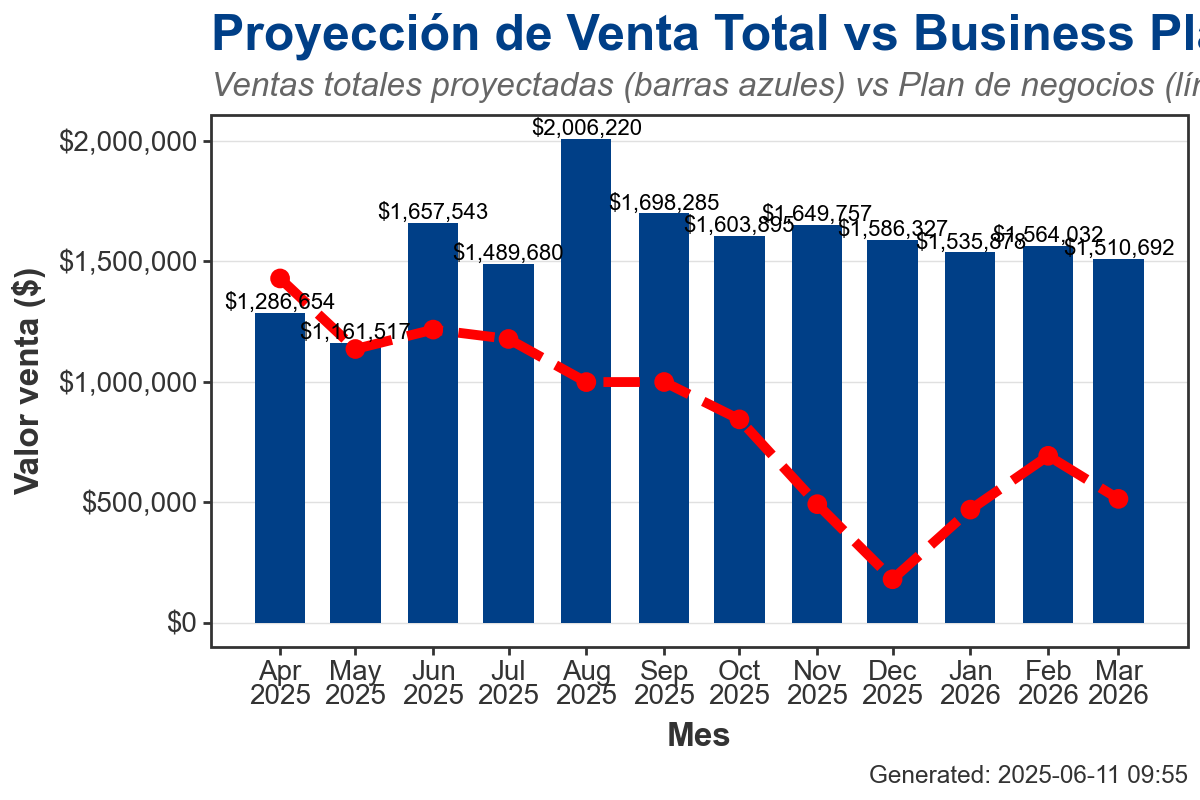

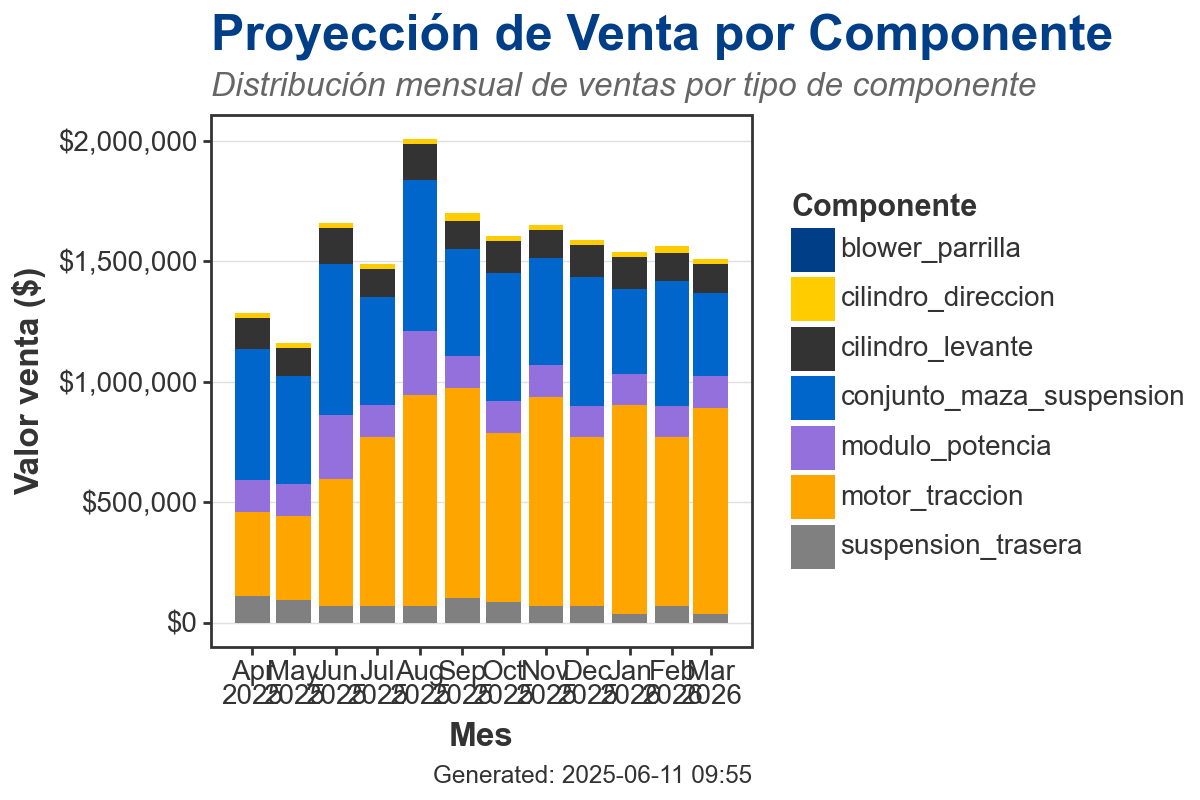

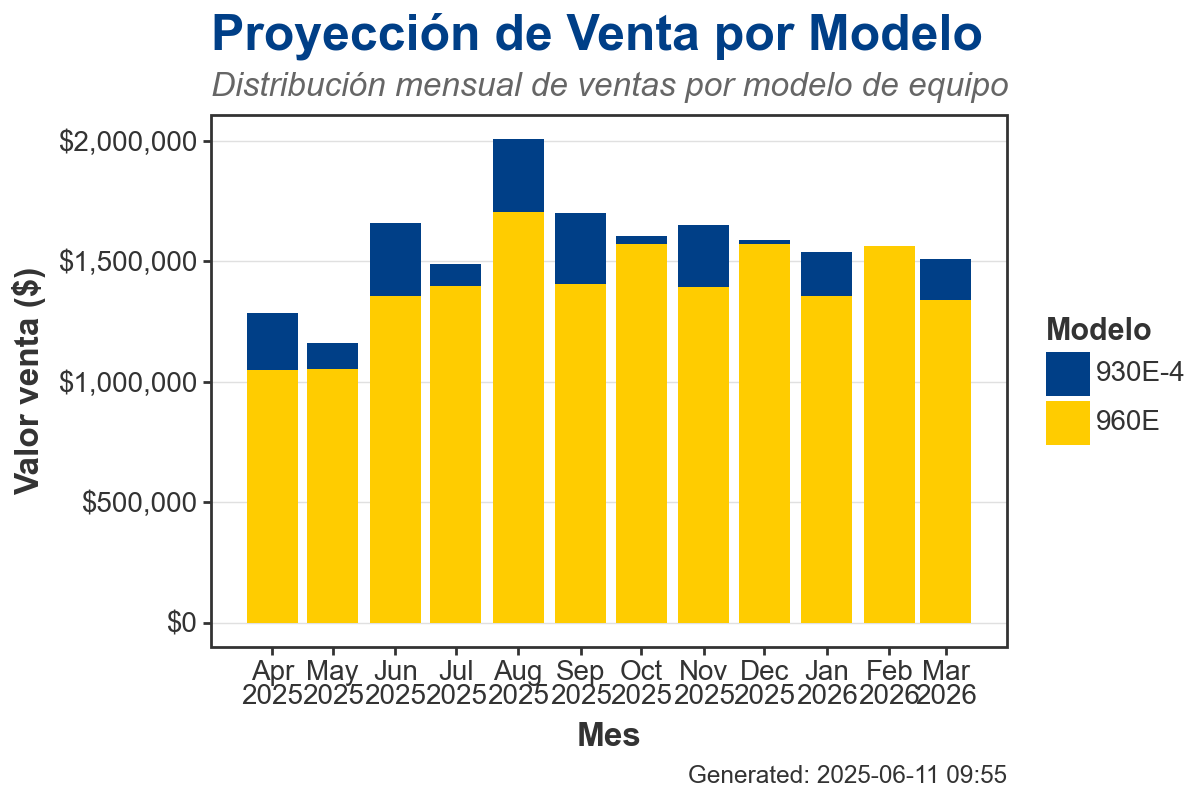

In [30]:
# Prepare business plan data
bp_df = pl.DataFrame(
    [
        {"month_date": "2025-04-01", "business_plan_sale": 1427986},
        {"month_date": "2025-05-01", "business_plan_sale": 1135285},
        {"month_date": "2025-06-01", "business_plan_sale": 1215772},
        {"month_date": "2025-07-01", "business_plan_sale": 1176895},
        {"month_date": "2025-08-01", "business_plan_sale": 998006},
        {"month_date": "2025-09-01", "business_plan_sale": 998347},
        {"month_date": "2025-10-01", "business_plan_sale": 843246},
        {"month_date": "2025-11-01", "business_plan_sale": 491517},
        {"month_date": "2025-12-01", "business_plan_sale": 179980},
        {"month_date": "2026-01-01", "business_plan_sale": 468983},
        {"month_date": "2026-02-01", "business_plan_sale": 692134},
        {"month_date": "2026-03-01", "business_plan_sale": 513376},
    ]
)
bp_df = bp_df.with_columns(pl.col("month_date").str.to_date().alias("month_date"))

# ============================================================================
# PLOT 1: Total Sales vs Business Plan (no stacking)
# ============================================================================

# Aggregate only by month (no grouping)
monthly_totals = (
    sale_df.with_columns(
        pl.date(
            pl.col("proj_changeout_date").dt.year(),
            pl.col("proj_changeout_date").dt.month(),
            1,
        ).alias("month_date")
    )
    .group_by("month_date")
    .agg(
        prorrata_sale=pl.col("prorrata_sale").sum(),
        cc_amount=pl.col("cc_amount").sum(),
    )
    .sort("month_date")
)

# Create simple bar plot with business plan line
plot1 = (
    p9.ggplot(monthly_totals.to_pandas(), p9.aes(x="month_date", y="prorrata_sale"))
    + p9.geom_col(fill=KOMATSU_COLORS["primary_blue"], width=20)
    # Add business plan line
    + p9.geom_line(
        data=bp_df.to_pandas(),
        mapping=p9.aes(x="month_date", y="business_plan_sale"),
        color="red",
        size=2,
        linetype="dashed",
    )
    + p9.geom_point(
        data=bp_df.to_pandas(),
        mapping=p9.aes(x="month_date", y="business_plan_sale"),
        color="red",
        size=3,
    )
    # Add value labels on bars
    + p9.geom_text(
        p9.aes(label="prorrata_sale"), va="bottom", size=8, format_string="${:,.0f}"
    )
    # Formatting
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Proyección de Venta Total vs Business Plan",
        subtitle="Ventas totales proyectadas (barras azules) vs Plan de negocios (línea roja)",
        x="Mes",
        y="Valor venta ($)",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(6, 4))
)

# ============================================================================
# PLOT 2: Stacked by Component Name
# ============================================================================

# Aggregate by month and component
monthly_by_component = (
    sale_df.with_columns(
        pl.date(
            pl.col("proj_changeout_date").dt.year(),
            pl.col("proj_changeout_date").dt.month(),
            1,
        ).alias("month_date")
    )
    .group_by(["month_date", "component_name"])
    .agg(
        prorrata_sale=pl.col("prorrata_sale").sum(),
        cc_amount=pl.col("cc_amount").sum(),
    )
    .sort(["month_date", "component_name"])
)

# Create stacked bar plot by component
plot2 = (
    p9.ggplot(
        monthly_by_component.to_pandas(),
        p9.aes(x="month_date", y="prorrata_sale", fill="component_name"),
    )
    + p9.geom_col(position="stack")
    + p9.scale_fill_manual(values=COMPONENT_COLORS, name="Componente")
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Proyección de Venta por Componente",
        subtitle="Distribución mensual de ventas por tipo de componente",
        x="Mes",
        y="Valor venta ($)",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(6, 4))
)

# ============================================================================
# PLOT 3: Stacked by Model Name
# ============================================================================

# Aggregate by month and model
monthly_by_model = (
    sale_df.with_columns(
        pl.date(
            pl.col("proj_changeout_date").dt.year(),
            pl.col("proj_changeout_date").dt.month(),
            1,
        ).alias("month_date")
    )
    .group_by(["month_date", "model_name"])
    .agg(
        prorrata_sale=pl.col("prorrata_sale").sum(),
        cc_amount=pl.col("cc_amount").sum(),
    )
    .sort(["month_date", "model_name"])
)

# Create stacked bar plot by model
plot3 = (
    p9.ggplot(
        monthly_by_model.to_pandas(),
        p9.aes(x="month_date", y="prorrata_sale", fill="model_name"),
    )
    + p9.geom_col(position="stack")
    + p9.scale_fill_manual(values=COMPONENT_COLORS, name="Modelo")
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Proyección de Venta por Modelo",
        subtitle="Distribución mensual de ventas por modelo de equipo",
        x="Mes",
        y="Valor venta ($)",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(6, 4))
)
display(plot1)
display(plot2)
display(plot3)

In [27]:
# Assuming bp_df and monthly_totals are already available as Polars DataFrames
# Join the dataframes
df_merged = monthly_totals.join(bp_df, on="month_date", how="left")

# Calculate variance columns
df_merged = df_merged.with_columns(
    [
        (pl.col("prorrata_sale") - pl.col("business_plan_sale")).alias("variance"),
        (
            (pl.col("prorrata_sale") - pl.col("business_plan_sale"))
            / pl.col("business_plan_sale")
            * 100
        ).alias("variance_pct"),
    ]
)

# Add month name column
df_merged = df_merged.with_columns(
    pl.col("month_date").dt.strftime("%B %Y").alias("month")
)

# Select and reorder columns
df_final = df_merged.select(
    [
        "month",
        "prorrata_sale",
        "business_plan_sale",
        "variance",
        "variance_pct",
        "cc_amount",
    ]
)

# Calculate totals
totals = pl.DataFrame(
    {
        "month": ["Total"],
        "prorrata_sale": [df_final["prorrata_sale"].sum()],
        "business_plan_sale": [df_final["business_plan_sale"].sum()],
        "variance": [df_final["variance"].sum()],
        "variance_pct": [
            (df_final["prorrata_sale"].sum() / df_final["business_plan_sale"].sum() - 1)
            * 100
        ],
        "cc_amount": [df_final["cc_amount"].sum()],
    }
)

# Append totals
df_with_totals = pl.concat([df_final, totals])

# Convert to pandas for GT (GT works with pandas)
df_pandas = df_with_totals.to_pandas()

# Create a simple GT table - minimal formatting to avoid errors
gt_table = (
    GT(df_pandas)
    .tab_header(title="Sales Performance Report")
    .cols_label(
        month="Month",
        prorrata_sale="Pro-rata Sale",
        business_plan_sale="Business Plan",
        variance="Variance ($)",
        variance_pct="Variance (%)",
        cc_amount="CC Count",
    )
    .fmt_currency(
        columns=["prorrata_sale", "business_plan_sale", "variance"], currency="USD"
    )
    .fmt_number(columns=["variance_pct"], decimals=1)
    .fmt_number(columns=["cc_amount"], decimals=0)
)
gt_table

GT(_tbl_data=             month  prorrata_sale  business_plan_sale   variance  \
0       April 2025      1286654.0             1427986  -141332.0   
1         May 2025      1161517.0             1135285    26232.0   
2        June 2025      1657543.0             1215772   441771.0   
3        July 2025      1489680.0             1176895   312785.0   
4      August 2025      2006220.0              998006  1008214.0   
5   September 2025      1698285.0              998347   699938.0   
6     October 2025      1603895.0              843246   760649.0   
7    November 2025      1649757.0              491517  1158240.0   
8    December 2025      1586327.0              179980  1406347.0   
9     January 2026      1535878.0              468983  1066895.0   
10   February 2026      1564032.0              692134   871898.0   
11      March 2026      1510692.0              513376   997316.0   
12           Total     18750480.0            10141527  8608953.0   

    variance_pct  cc_amount  
0      -9.897296         22  
1       2.310609         19  
2      36.336665         21  
3      26.577137         17  
4     101.022840         21  
5      70.109691         20  
6      90.204875         18  
7     235.645970         19  
8     781.390710         18  
9     227.491188         16  
10    125.972427         16  
11    194.266191         17  
12     84.888134        224  , _body=<great_tables._gt_data.Body object at 0x000001D7F2379430>, _boxhead=Boxhead([ColInfo(var='month', type=<ColInfoTypeEnum.default: 1>, column_label='Month', column_align='left', column_width=None), ColInfo(var='prorrata_sale', type=<ColInfoTypeEnum.default: 1>, column_label='Pro-rata Sale', column_align='right', column_width=None), ColInfo(var='business_plan_sale', type=<ColInfoTypeEnum.default: 1>, column_label='Business Plan', column_align='right', column_width=None), ColInfo(var='variance', type=<ColInfoTypeEnum.default: 1>, column_label='Variance ($)', column_align='right', column_width=None), ColInfo(var='variance_pct', type=<ColInfoTypeEnum.default: 1>, column_label='Variance (%)', column_align='right', column_width=None), ColInfo(var='cc_amount', type=<ColInfoTypeEnum.default: 1>, column_label='CC Count', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001D7F205FFE0>, _spanners=Spanners([]), _heading=Heading(title='Sales Performance Report', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001D7F2389AC0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001D7F237B200>, <great_tables._gt_data.FormatInfo object at 0x000001D7F243B5F0>, <great_tables._gt_data.FormatInfo object at 0x000001D7F243BA40>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font


### Anális
 por cambio y costo

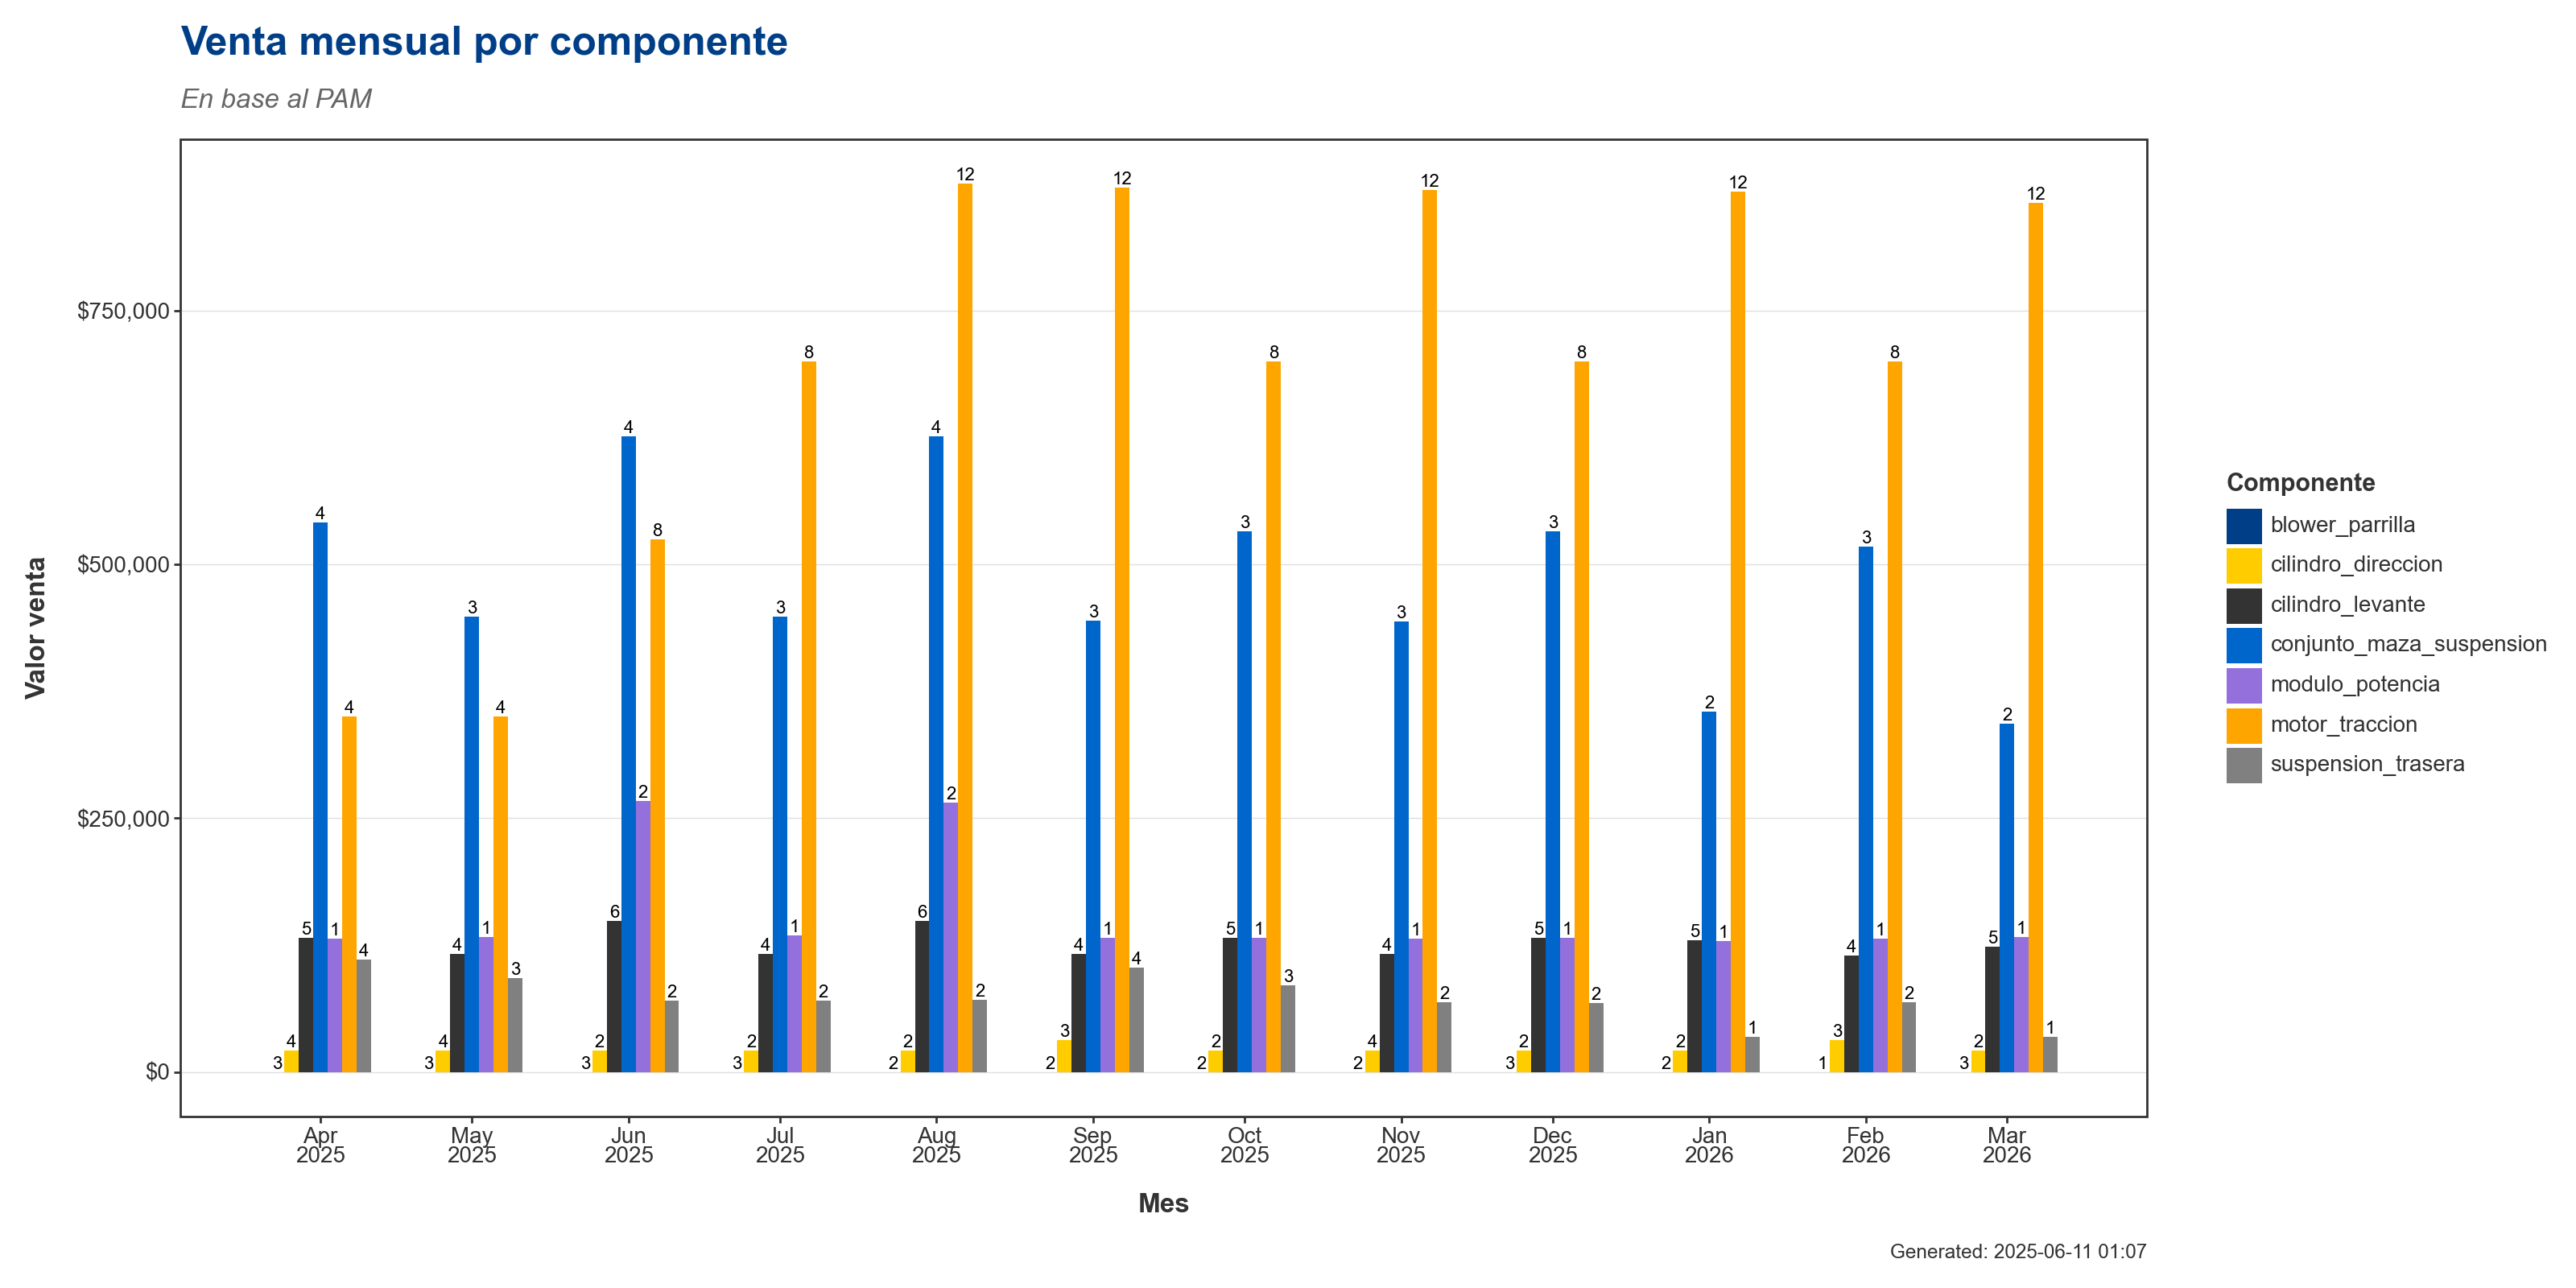

In [184]:
# Step 1: Prepare the data - aggregate by month and component
monthly_component_data = (
    sale_df.with_columns(
        [
            pl.col("proj_changeout_date").dt.year().alias("year"),
            pl.col("proj_changeout_date").dt.month().alias("month"),
            pl.date(
                pl.col("proj_changeout_date").dt.year(),
                pl.col("proj_changeout_date").dt.month(),
                1,
            ).alias("month_date"),
        ]
    )
    .group_by(["month_date", "component_name"])
    .agg(
        [
            pl.col("prorrata_sale").sum().alias("total_prorrata_sale"),
            pl.col("cc_amount").sum().alias("total_changes"),  # Sum of changeouts
        ]
    )
    .sort(["month_date", "component_name"])
)

# Step 2: Create the grouped bar plot
plot = (
    p9.ggplot(
        monthly_component_data.to_pandas(),
        p9.aes(x="month_date", y="total_prorrata_sale", fill="component_name"),
    )
    + p9.geom_col(position="dodge", width=20)  # width in days for datetime
    + p9.geom_text(
        p9.aes(label="total_changes"),
        position=p9.position_dodge(width=20),
        va="bottom",
        size=8,
        format_string="{:.0f}",  # Format as integer
    )
    + p9.scale_fill_manual(values=COMPONENT_COLORS, name="Componente")
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Venta mensual por componente",
        subtitle="En base al PAM",
        x="Mes",
        y="Valor venta",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(16, 8))  # Wider for grouped bars
)
plot